In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import timedelta

# sns.set( style = 'darkgrid' )

# Data Cleaning and Visualization

In [9]:
df = pd.read_csv( './Sensado_Vestidores_Completo.csv', encoding = 'ISO-8859-1', parse_dates = [ 'Fecha' ] )
df.columns = [ 'Date', 'Pre', 'Alt', 'Hum', 'Temp', 'Occ' ]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10136 entries, 0 to 10135
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10136 non-null  object 
 1   Pre     10136 non-null  float64
 2   Alt     10136 non-null  float64
 3   Hum     10133 non-null  float64
 4   Temp    10136 non-null  float64
 5   Occ     10136 non-null  object 
dtypes: float64(4), object(2)
memory usage: 475.2+ KB


## Filling null values

In [10]:
len( df ) - df.count()

Date    0
Pre     0
Alt     0
Hum     3
Temp    0
Occ     0
dtype: int64

In [11]:
df[ 'Hum' ].fillna( method ='ffill', inplace = True )
len( df ) - df.count()

Date    0
Pre     0
Alt     0
Hum     0
Temp    0
Occ     0
dtype: int64

## Visualization 

### Visualizing the complete dataset

In [14]:
from scipy.stats import pearsonr

def pearson_corr( x, y, **kws ):
    ( r, p ) = pearsonr( x, y )
    ax = plt.gca()
    ax.annotate( "r = {:.2f} ".format( r ),
                xy = (.1, .9), xycoords = ax.transAxes )

def make_patch_spines_invisible( ax ):
    ax.set_frame_on( True )
    ax.patch.set_visible( False )
    for sp in ax.spines.values():
        sp.set_visible( False )
        
def plot_env_vars( x, temp, hum, occ, title = 'Temperature, Humidity and Occupancy' ):
    fig, host = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
    
    par1 = host.twinx()
    par2 = host.twinx()

    par2.spines[ 'right' ].set_position( ( 'axes', 1.04 ) )
    make_patch_spines_invisible( par2 )
    par2.spines[ 'right' ].set_visible( True )
    
    g1,  = host.plot( x, temp, 'royalblue', label = 'Temp' )
    g2,  = par1.plot( x, hum, 'forestgreen', label = 'Hum' )
    g3,  = par2.plot( x, occ.replace( { 'L': 0, 'M':1, 'H':2 } ), 'lightcoral', label = 'Occ' )
    
    host.set_xlabel( 'Date' )
    host.set_ylabel( 'Temp')
    par1.set_ylabel( 'Hum' )
    par2.set_ylabel( 'Occ' )
    
    par2.set_ylim( 0, 10 )
    par2.yaxis.set_major_locator( plt.IndexLocator( base = 1, offset = 0 ) )
    host.xaxis.set_major_locator( plt.AutoLocator() )
    
    plots = [ g1, g2, g3 ]
    host.legend( plots, [ l.get_label() for l in plots ] )
    
    fig.autofmt_xdate()
    plt.title( title )
    plt.show()
    
def plot_single( x, y, name ):
    fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
    
    g, = plt.plot( x, y, 'royalblue', label = name )
    
    ax.xaxis.set_major_locator( plt.AutoLocator() )
    ax.legend( [ g ], [ g.get_label() ] )
    ax.set_ylabel( name.capitalize() )
    
    fig.autofmt_xdate()
    plt.title( name.capitalize(), fontsize = 16 )
    plt.show()

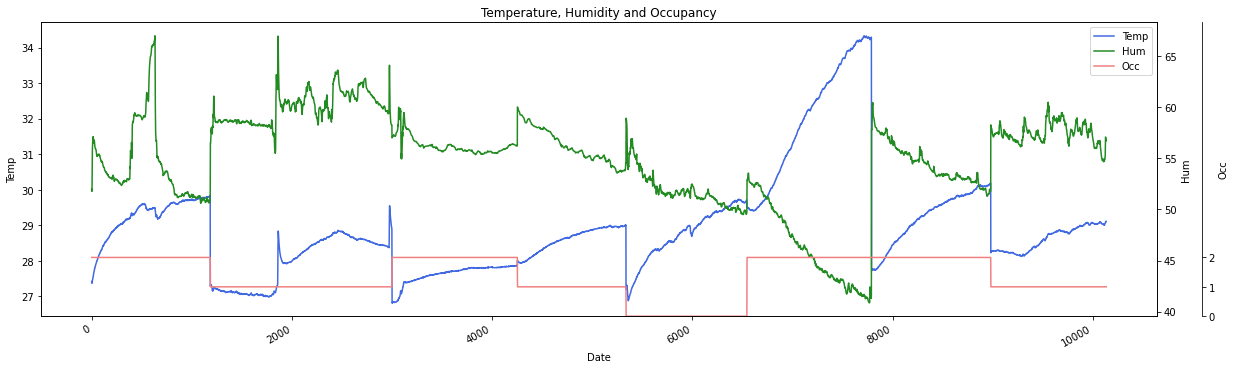

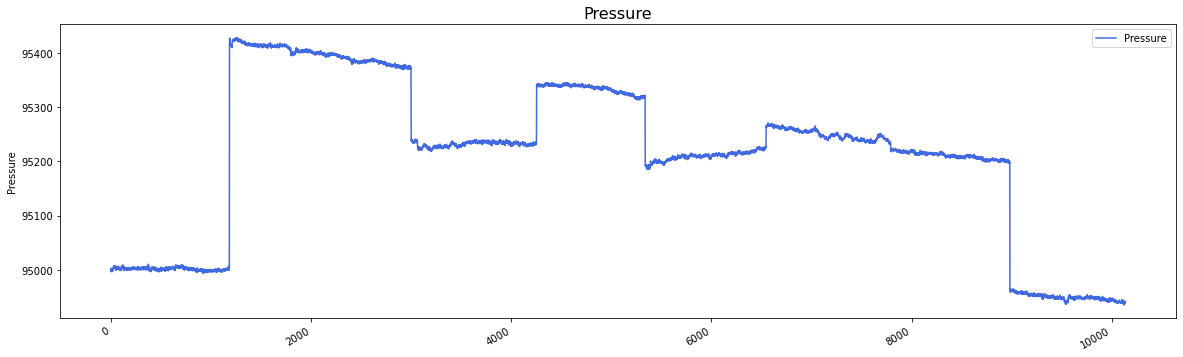

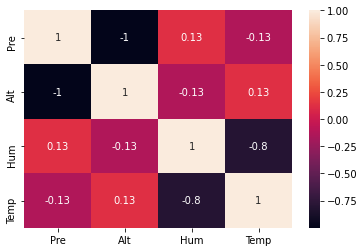

In [15]:
plot_env_vars( df.index, df[ 'Temp' ], df[ 'Hum' ], df[ 'Occ' ] )
plot_single( df.index, df[ 'Pre' ], 'Pressure' )
sns.heatmap( df.corr(), annot = True )

# Preparing Datasets

The dataset present error values in the date column. 6.5k of 10k instances have this issue, so the vast majority of the dataset dates are corrupted. Because of this we are going to generate distinct datasets resolutions discarting the corrupted data in all the cases except for the 10 seconds, which will be generated averaging ten intances (which corresponds aproximately to a 10 sec. period )

In [27]:
import enum

class DF( enum.Enum ):
    _OR = 0
    _10SEC = 1
    _1MIN = 2
    _5MIN = 3

AGG = [ 'mean' ]
dfs = { DF._OR: df, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None }
grids = { 
    'svc': { DF._OR: None, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None },
    'knn': { DF._OR: None, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None },
    'dt': { DF._OR: None, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None } }

## Datasets generation

### 10 sec. avg.

In [28]:
# generating the dataset in 10s intervals

def agg_date( col ):
    return col.iloc[ 0 ] # left labeling

def agg_occupancy( col ): 
    return col.mode()[ 0 ]

def groupby_10( g, agg ):
    return g.groupby( np.arange( len( g ) ) // 10 ).agg( { 
        'Date': agg_date, 
        'Occ': agg_occupancy,
        'Pre': agg, 
        'Alt': agg, 
        'Hum': agg, 
        'Temp': agg } )

temp = ( groupby_10( df, AGG ).reset_index( drop = True ) )
temp.columns = [ c[ 0 ] for c in temp.columns ]

temp = ( temp
    .rename( columns = { 'Date_agg_date': 'Date', 'Occ_agg_occupancy': 'Occ' } )
    .sort_values( by = 'Date' )
    .reset_index( drop = True ) )

dfs[ DF._10SEC ] = temp

### 1 minute samples

In [29]:
def is_date( value ):
    try:
        pd.to_datetime( value )
        return True
    except:
        return False

temp = df.loc[ df[ 'Date' ].apply( is_date ) ]
temp.loc[ :, 'Date' ] = pd.to_datetime( temp[ 'Date' ] )
dfs[ DF._1MIN ] = ( temp
        .set_index( 'Date' )
        .resample( '1 min' )
        .first()
        .dropna( axis = 0, how = 'any' )
        .reset_index() )

/Users/Andree/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### 5 minutes samples

This dataset is too small, it just has 15 instances. Hence we will not used.

In [30]:
( temp
    .set_index( 'Date' )
    .resample( '5 min' )
    .first()
    .dropna( axis = 0, how = 'any' )
    .reset_index() )
del dfs[ DF._5MIN ] # removing from dict

## Standarization

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_TRAIN = 0
X_TEST = 1
Y_TRAIN = 2
Y_TEST = 3

def standarize( df ):
    x_train, x_test, y_train, y_test = train_test_split( 
        df.drop( [ 'Occ', 'Date' ], axis = 1 ), 
        df.Occ, 
        test_size = .20, 
        random_state = 0 )
    
    scaler = StandardScaler()
    scaler.fit( x_train )

    x_train = scaler.transform( x_train )
    x_test = scaler.transform( x_test )
    
    return x_train, x_test, y_train, y_test

for k, d in dfs.items() : 
    x_train, x_test, y_train, y_test = standarize( d )
    dfs[ k ] = [ x_train, x_test, y_train, y_test ]

## Balancing classes

In [32]:
from imblearn.over_sampling import ADASYN, SMOTE
from collections import Counter

neighborgs = { DF._OR: 165, DF._10SEC: 1, DF._1MIN: 16, DF._5MIN: 3 }


for k, d in dfs.items() :    
    if( k in [ DF._OR, DF._10SEC ] ):     
        oversampler = ADASYN( 
            sampling_strategy = 'not majority', 
            n_neighbors = neighborgs[ k ], 
            random_state = 42 )
    else:
        oversampler = SMOTE( 
            sampling_strategy = 'not majority', 
            k_neighbors = neighborgs[ k ],
            random_state = 42 ) 
        
    x_train, y_train = oversampler.fit_resample( d[ X_TRAIN ], d[ Y_TRAIN ] )
    
    print( 'Before:', k, Counter( d[ Y_TRAIN ] ) )
    d[ X_TRAIN ] = x_train
    d[ Y_TRAIN ] = y_train
    print( 'After:', k, Counter( y_train ) )
    print()

Before: DF._OR Counter({'L': 3905, 'H': 3902, 'M': 3902})
After: DF._OR Counter({'L': 3905, 'H': 3902, 'M': 3902})

Before: DF._10SEC Counter({'M': 389, 'H': 389, 'L': 388})
After: DF._10SEC Counter({'M': 389, 'H': 389, 'L': 388})

Before: DF._1MIN Counter({'M': 33, 'H': 33})
After: DF._1MIN Counter({'M': 33, 'H': 33})



# Classificaton

In [34]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.decomposition import PCA



def grid_search( estimator, params ):
    scoring = 'accuracy'
    cv_method = RepeatedStratifiedKFold( n_splits = 10, n_repeats = 2, random_state = 0 )
    
    return GridSearchCV( 
        estimator = estimator,
        param_grid = params,
        cv = cv_method,
        verbose = False,
        scoring = scoring,
        return_train_score = True )


def train_and_test( estimator, params, x_train, y_train, 
                   x_test, y_test, plot_cmatrix = False ):
    
    grid = grid_search( estimator, params )
    
    # Training and evaluation

    grid.fit( x_train, y_train );
    print( 'Best params: ', grid.best_params_ )
    print( 'Training Accuracy', grid.best_score_ )

    y_pred = grid.best_estimator_.predict( x_test )
    print( 'Test Accuracy: ', accuracy_score( y_test, y_pred ) )
    
    if( plot_cmatrix ) :
        fig, ax = plt.subplots( 1, 1 )
        g = sns.heatmap( confusion_matrix( y_test, y_pred ), annot = True, cmap = "YlGnBu" )
        g.set_title( 'Test Confussion Matrix' )
    
    return grid

## Regular

### SVM

In [35]:
params_svc = [ { 
    'C': [ .1, 1, 10, 100 ], 
    'kernel': [ 'linear', 'poly' ] 
}, { 
    'C': [ .1, 1, 10, 100 ], 
    'kernel': [ 'rbf' ],
    'gamma': [ 10, 1, 0.1, 0.01, 0.001 ]
} ]

print( '-----------------------------------' )
print( 'Regular datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    if( k != DF._OR ):
        print( 'Dataset ', k )
        train_and_test( 
                svm.SVC(), params_svc, 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

-----------------------------------
Regular datasets
-----------------------------------
Dataset  DF._10SEC
Best params:  {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
Training Accuracy 0.9991452991452991
Test Accuracy:  1.0
Dataset  DF._1MIN
Best params:  {'C': 0.1, 'kernel': 'linear'}
Training Accuracy 1.0
Test Accuracy:  1.0


### KNN

In [36]:
params_knn = [ { 
    'n_neighbors': [ 1, 3, 8, 13 ], 
    'p': [ 1, 2 ], # mikowsky distance
    'algorithm': [ 'brute', 'ball_tree', 'kd_tree' ]
} ]

print( '-----------------------------------' )
print( 'Regular datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    train_and_test( KNeighborsClassifier(), params_knn, 
                   df[ X_TRAIN ], df[ Y_TRAIN ], 
                   df[ X_TEST ], df[ Y_TEST ] )

-----------------------------------
Regular datasets
-----------------------------------
Dataset  DF._OR
Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
Training Accuracy 1.0
Test Accuracy:  1.0
Dataset  DF._10SEC
Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
Training Accuracy 0.9995726495726496
Test Accuracy:  1.0
Dataset  DF._1MIN
Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
Training Accuracy 1.0
Test Accuracy:  1.0


### Decision Trees

In [37]:
params_dt = [ { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ]
} ]

print( '-----------------------------------' )
print( 'Regular datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    train_and_test( DecisionTreeClassifier(), params_dt, 
                   df[ X_TRAIN ], df[ Y_TRAIN ], 
                   df[ X_TEST ], df[ Y_TEST ] )

-----------------------------------
Regular datasets
-----------------------------------
Dataset  DF._OR
Best params:  {'criterion': 'gini', 'max_depth': 12}
Training Accuracy 0.9997865072587533
Test Accuracy:  0.9995069033530573
Dataset  DF._10SEC
Best params:  {'criterion': 'entropy', 'max_depth': 8}
Training Accuracy 0.9948644267609785
Test Accuracy:  0.9950738916256158
Dataset  DF._1MIN
Best params:  {'criterion': 'gini', 'max_depth': 2}
Training Accuracy 1.0
Test Accuracy:  1.0


## PCA

In [38]:
def add_pca_estimator( estimator ):
    return Pipeline( [ ( 'reduce_dim', PCA( .95 ) ),  ( 'clf', estimator ) ] )
    
def prefix_params( d_list, prefix ):
    result = []
    for d in d_list: 
        temp = {}
        for key in d.keys():
            temp[ prefix + '__' + key ] = d[ key ]
        result.append( temp )
    return result

In [39]:
# x_train_pca = pca.transform( x_train )
# x_test_pca = pca.transform( x_test )

# columns = [ 'PCA_' + str( i ) for i in range( 1, pca.n_components_ + 1 ) ]
# df_temp = pd.DataFrame( data = x_train_pca, columns = columns )
# df_temp.set_index( y_train.index, drop = True, inplace = True )
# df_temp = pd.concat( [ df_temp, y_train ], axis = 1 )
# df_temp

In [40]:
# fig, ax = plt.subplots( 1, 1, figsize = ( 12, 4 ) )
# plt.ylim( 0, 100 )
# g = sns.barplot( x = columns, y = pca.explained_variance_ratio_ * 100 )
# g.set_xlabel( 'Component' )
# g.set_ylabel( 'Variance explained (%)' )
# g.set_title( 'Variance explained by Component' )

In [41]:
print( '-----------------------------------' )
print( 'PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    if( k != DF._OR ): # the original dataset does not converge
        print( 'Dataset ', k )
        grids[ 'svc' ][ k ] = train_and_test( 
                add_pca_estimator( svm.SVC() ), 
                prefix_params( params_svc, 'clf' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

-----------------------------------
PCA datasets
-----------------------------------
Dataset  DF._10SEC
Best params:  {'clf__C': 1, 'clf__gamma': 10, 'clf__kernel': 'rbf'}
Training Accuracy 0.9991452991452991
Test Accuracy:  1.0
Dataset  DF._1MIN
Best params:  {'clf__C': 0.1, 'clf__kernel': 'linear'}
Training Accuracy 1.0
Test Accuracy:  1.0


### KNN

In [42]:
print( '-----------------------------------' )
print( 'PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    grids[ 'knn' ][ k ] = train_and_test( 
                add_pca_estimator( KNeighborsClassifier() ), 
                prefix_params( params_knn, 'clf' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

-----------------------------------
PCA datasets
-----------------------------------
Dataset  DF._OR
Best params:  {'clf__algorithm': 'brute', 'clf__n_neighbors': 1, 'clf__p': 1}
Training Accuracy 1.0
Test Accuracy:  1.0
Dataset  DF._10SEC
Best params:  {'clf__algorithm': 'brute', 'clf__n_neighbors': 1, 'clf__p': 1}
Training Accuracy 0.9991416150898911
Test Accuracy:  1.0
Dataset  DF._1MIN
Best params:  {'clf__algorithm': 'brute', 'clf__n_neighbors': 1, 'clf__p': 1}
Training Accuracy 1.0
Test Accuracy:  1.0


### Decision Trees

# print( '-----------------------------------' )
print( 'Testing with PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    grids[ 'dt' ][ k ] = train_and_test( 
        add_pca_estimator( DecisionTreeClassifier() ), 
        prefix_params( params_dt, 'clf' ), 
        df[ X_TRAIN ], df[ Y_TRAIN ], 
        df[ X_TEST ], df[ Y_TEST ] )

# Evaluation

In [59]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit

def plot_learning_curve( estimator, title, X, y, axes = None, ylim = None, cv = None,
                        n_jobs = None, train_sizes = np.linspace( .1, 1.0, 5 ) ):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim( *ylim )
    axes[0].set_xlabel( 'Training examples' )
    axes[0].set_ylabel( 'Score' )

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve( estimator, X, y, cv = cv, n_jobs = n_jobs,
                       train_sizes = train_sizes,
                       return_times = True )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    
    axes[0].grid()
    axes[0].fill_between( train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha = 0.1,
                         color = 'r')
    axes[0].fill_between( train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha = 0.1,
                         color = 'g' )
    
    axes[0].plot( train_sizes, train_scores_mean, 'o-', color = 'r',
                 label = 'Training score' )
    axes[0].plot( train_sizes, test_scores_mean, 'o-', color = 'g',
                 label = 'Cross-validation score' )
    axes[0].legend( loc = 'best' )

    
    # Plot n_samples vs fit_times
    
    axes[1].grid()
    axes[1].plot( train_sizes, fit_times_mean, 'o-' )
    axes[1].fill_between( train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha = 0.1 )
    axes[1].set_xlabel( 'Training examples' )
    axes[1].set_ylabel( 'fit_times' )
    axes[1].set_title( 'Scalability of the model' )
    
    
    # Plot fit_time vs score
    
    axes[2].grid()
    axes[2].plot( fit_times_mean, test_scores_mean, 'o-' )
    axes[2].fill_between( fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha = 0.1 )
    axes[2].set_xlabel( 'fit_times' )
    axes[2].set_ylabel( 'Performance of the model' )
    axes[2].set_title( 'Performance of the model' )

    return plt


def plot_learning_curves( dfs, grids ):
    fig, axes = plt.subplots( 3, len( dfs ), figsize=( 21, 15 ) )
    
    ax = 0
    for k, d in dfs:
        cv = StratifiedShuffleSplit( n_splits = 100, test_size = 0.2, random_state = 0 )
        title = 'Learning Curves with PCA ( ' + str( k ) + ' )'
        plot_learning_curve( grids[ k ].best_estimator_, 
                            title, 
                            d[ X_TRAIN ], d[ Y_TRAIN ], 
                            axes = axes[ :, ax ], 
                            ylim = ( 0.7, 1.01 ),
                            cv = cv, n_jobs = 4 )
        ax += 1

    plt.show()

## Learning Curves

### SVC

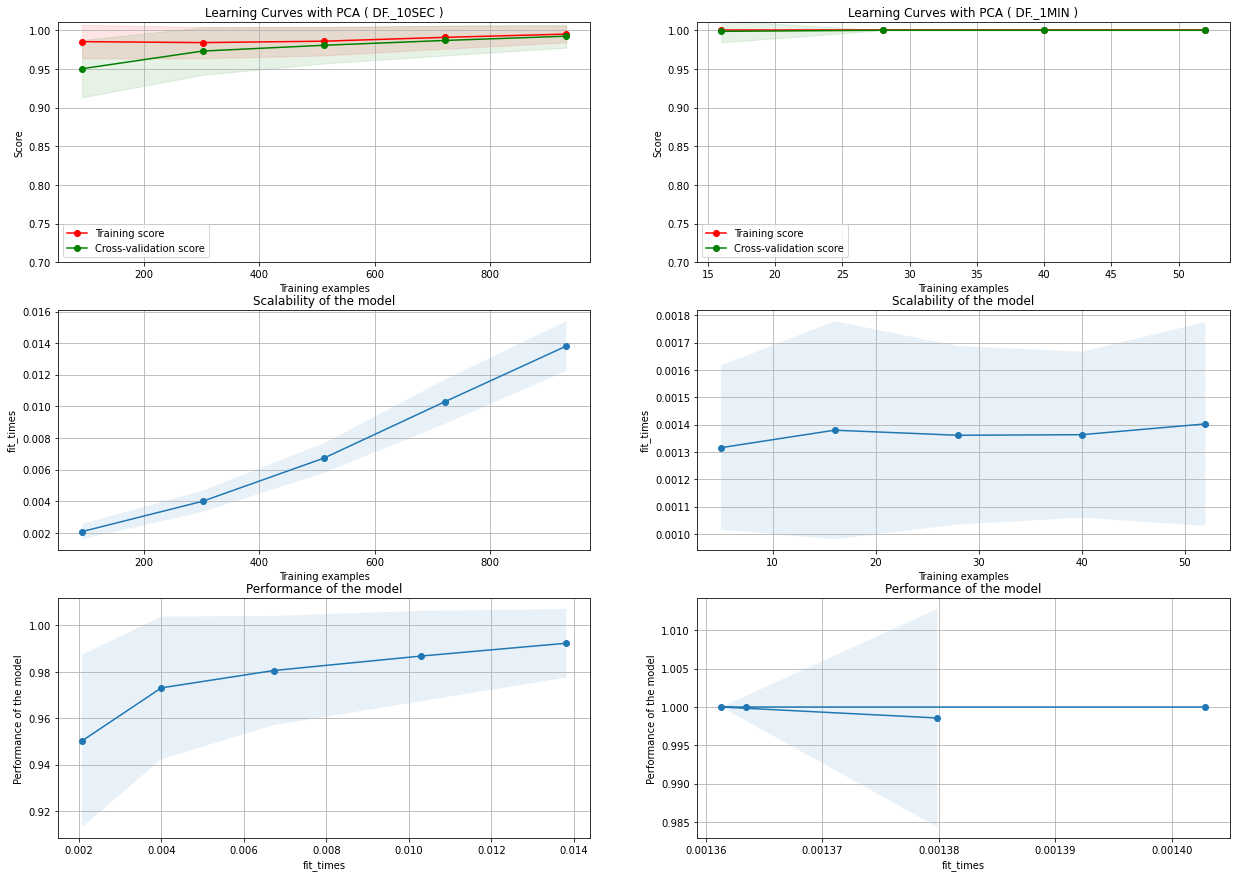

In [61]:
temp = [ item for item in dfs.items() if item[ 0 ] != DF._OR ]
plot_learning_curves( temp, grids[ 'svc' ] )

### KNN

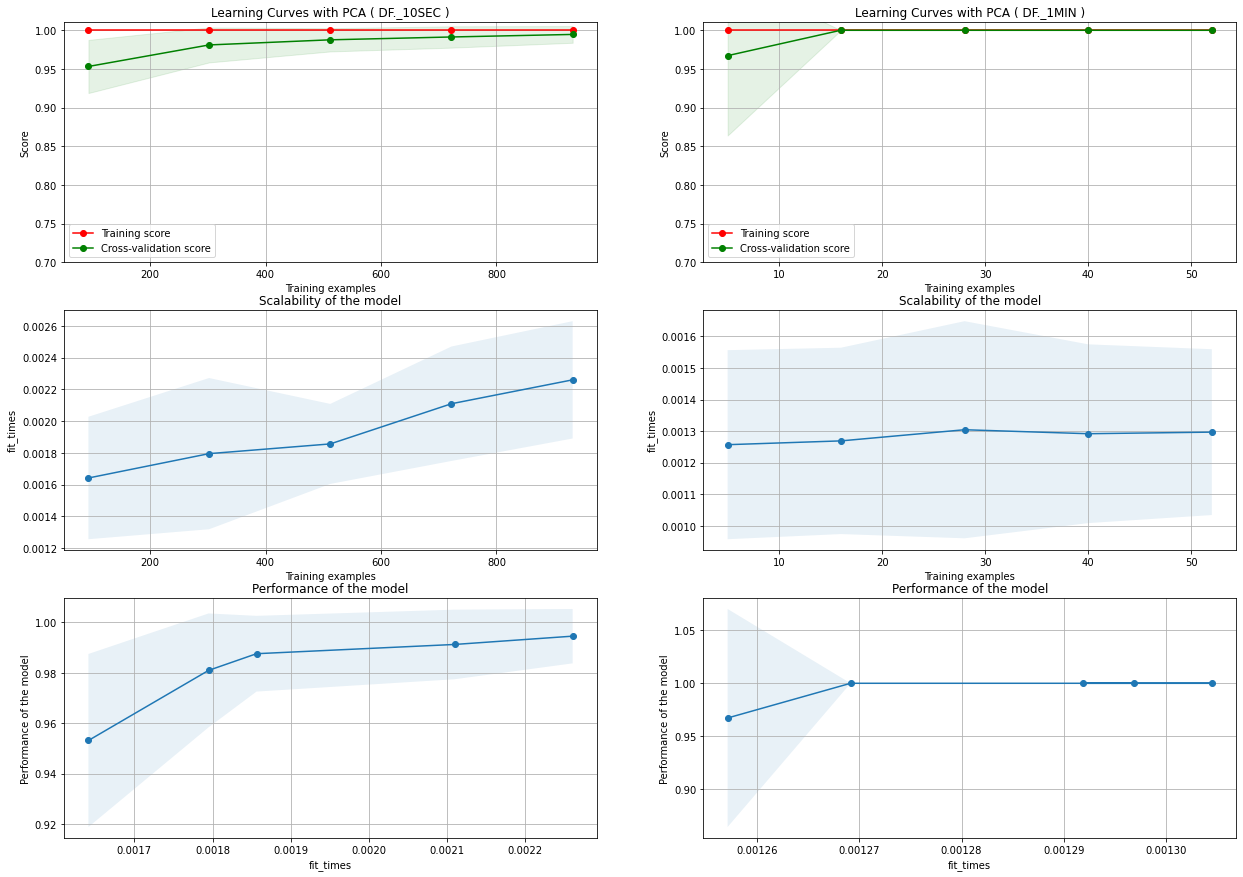

In [62]:
temp = [ item for item in dfs.items() if item[ 0 ] != DF._OR ]
plot_learning_curves( temp, grids[ 'knn' ] )

### DT

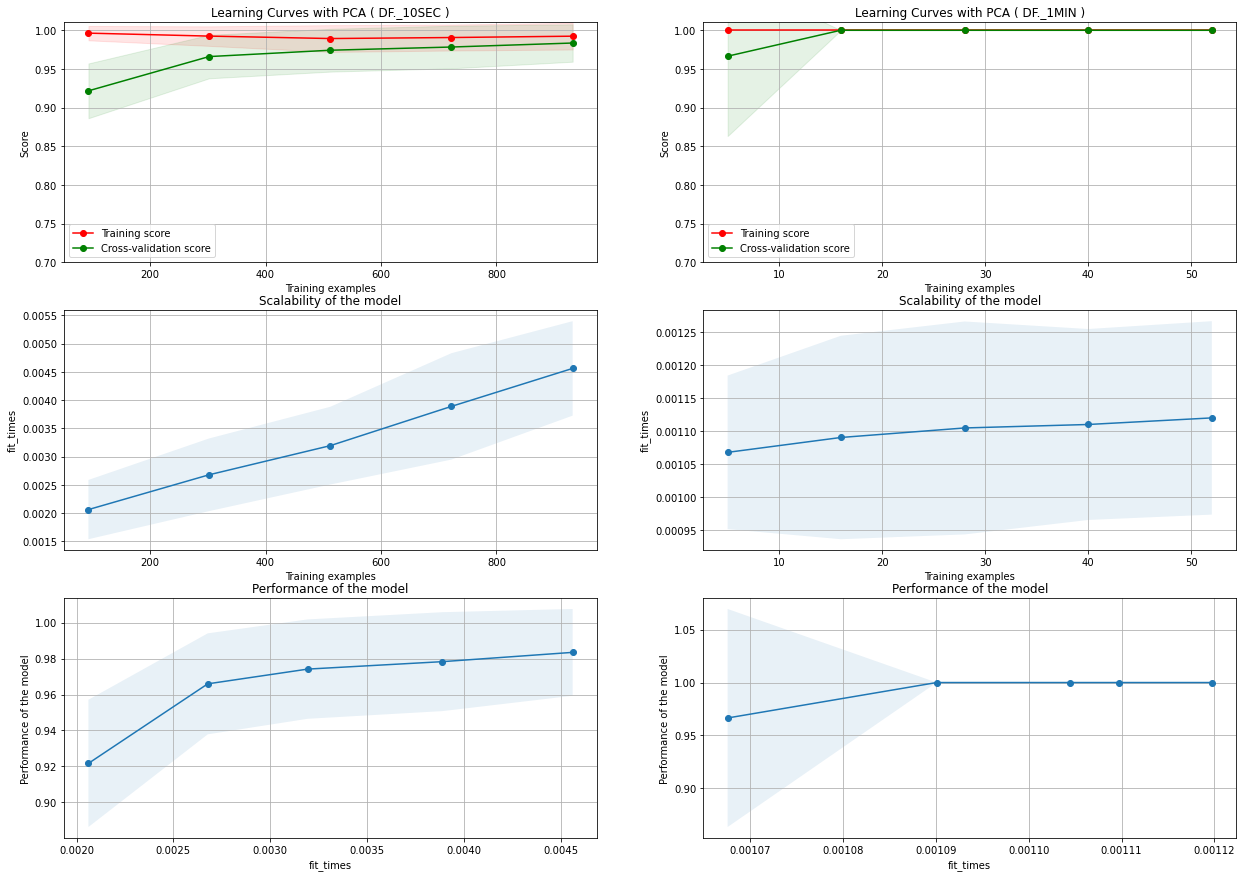

In [63]:
temp = [ item for item in dfs.items() if item[ 0 ] != DF._OR ]
plot_learning_curves( temp, grids[ 'dt' ] )